In [94]:
import sys
import os
sys.path.append("""/home/jonfrey/ASL/src""")
os.chdir("/home/jonfrey/ASL")

import torch
import numpy as np
from PIL import Image
import imageio
import pickle
from visu import Visualizer
from PIL import ImageDraw, ImageFont
from torchvision import transforms as tf

visu = Visualizer(os.getenv('HOME')+'/tmp', logger=None, epoch=0, store=False, num_classes=41)

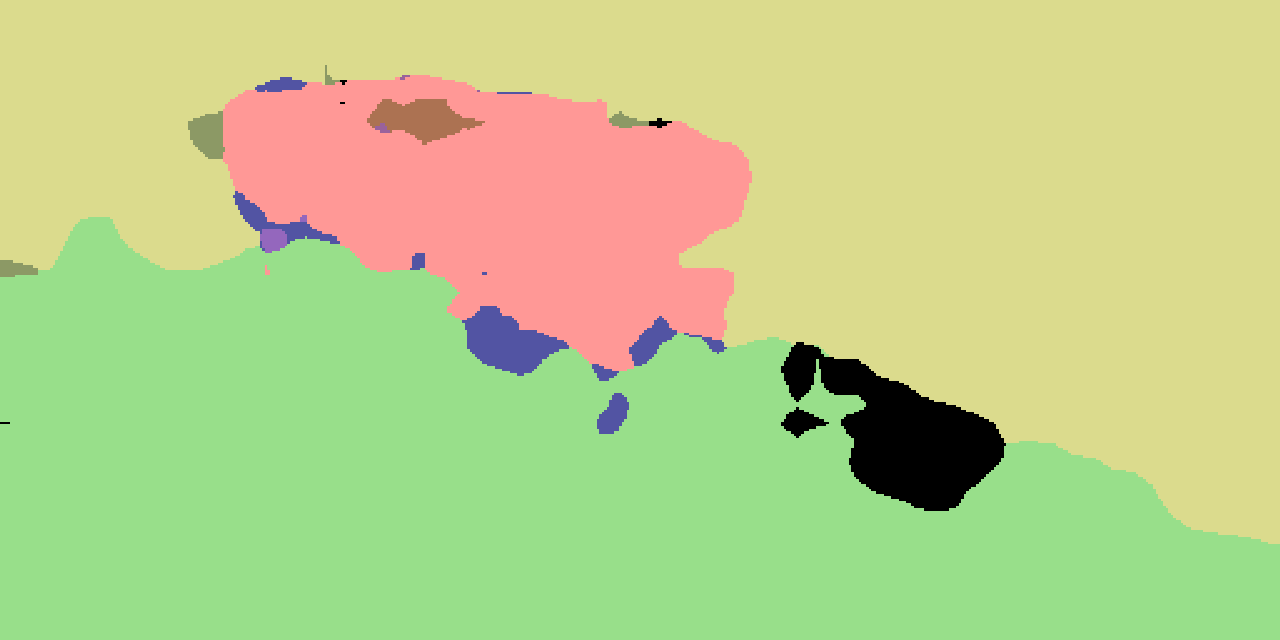

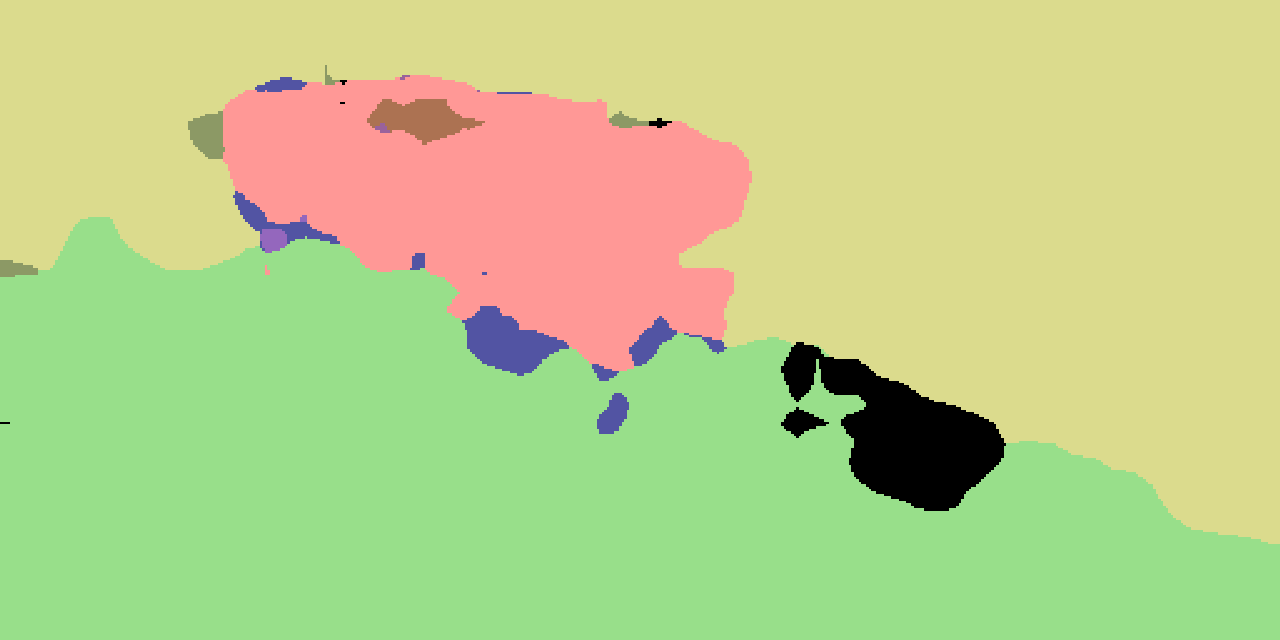

In [55]:
from pseudo_label import PseudoLabelGenerator
plg = PseudoLabelGenerator(visu=visu,visu_active=False)
from pseudo_label import readSegmentation
pred, target, valid = readSegmentation("/home/jonfrey/results/scannet_eval/run_24h_train_1gpu/scannet/scene0000_00/segmentation_deeblab_v3/50.png")
r= visu.plot_segmentation(seg=np.array( pred )+1,jupyter=True)
# r= visu.plot_segmentation(seg=np.array( target )+1,jupyter=True)
r= visu.plot_segmentation(seg=labelmap ,jupyter=True)

In [36]:
#!/usr/bin/env python
# coding: utf-8
#
# Author: Kazuto Nakashima
# URL:    https://kazuto1011.github.io
# Date:   09 January 2019


import numpy as np
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils




(640, 1280, 3)


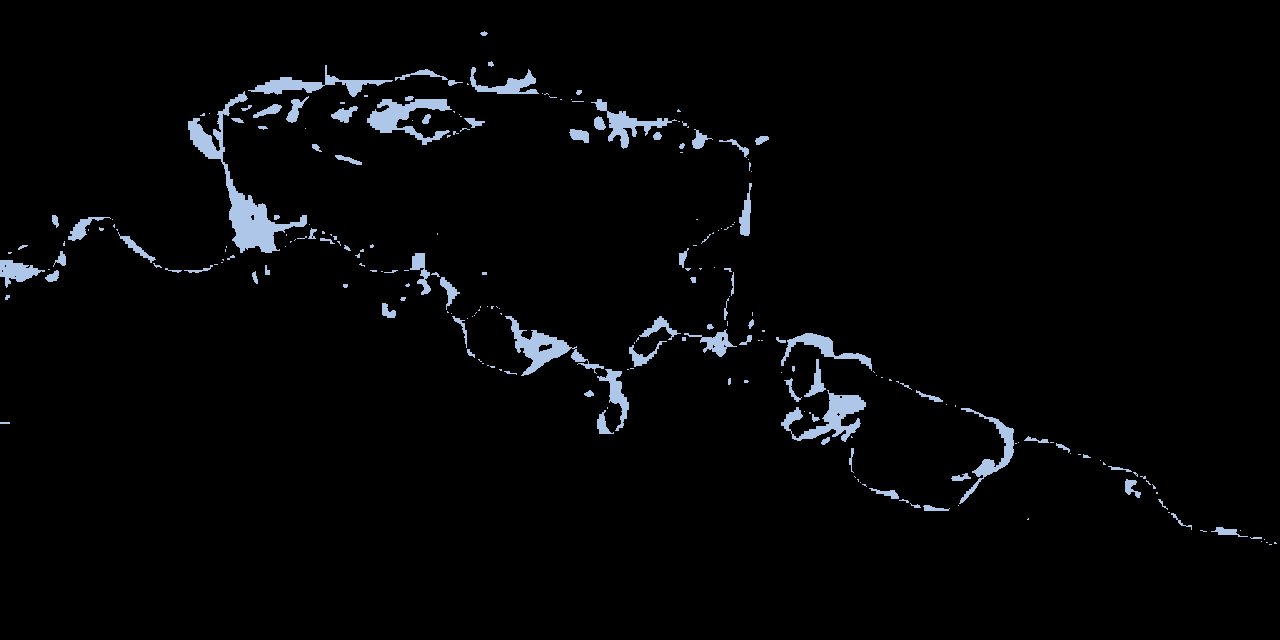

In [115]:
from pseudo_label import readImage

class DenseCRF(object):
    def __init__(self, iter_max, pos_w, pos_xy_std, bi_w, bi_xy_std, bi_rgb_std):
        self.iter_max = iter_max
        self.pos_w = pos_w
        self.pos_xy_std = pos_xy_std
        self.bi_w = bi_w
        self.bi_xy_std = bi_xy_std
        self.bi_rgb_std = bi_rgb_std

    def __call__(self, image, probmap):
        C, H, W = probmap.shape
        U = utils.unary_from_softmax(probmap)
        U = U.reshape((C,-1))
        U = np.ascontiguousarray(U)

        image = np.ascontiguousarray(image)

        d = dcrf.DenseCRF2D(W, H, C)
        d.setUnaryEnergy(U)
        d.addPairwiseGaussian(sxy=self.pos_xy_std, compat=self.pos_w)
        d.addPairwiseBilateral(
            sxy=self.bi_xy_std, srgb=self.bi_rgb_std, rgbim=image, compat=self.bi_w
        )

        Q = d.inference(self.iter_max)
        Q = np.array(Q).reshape((C, H, W))

        return Q

def setup_postprocessor():
    # Parameters used in deeplab v2
    postprocessor = DenseCRF(
        iter_max= 5,
        pos_xy_std=1,
        pos_w= 50,
        bi_xy_std= 100,
        bi_rgb_std= 3,
        bi_w= 50,
    )
    return postprocessor

def get_onehot(v, nc=41):
    n_values = np.max( nc )
    return np.eye(n_values)[v+1]

raw_image = readImage("/home/jonfrey/datasets/scannet/scans/scene0000_00/color/50.jpg")

from scipy.special import softmax
pred_onehot = get_onehot(pred)
pred_onehot = np.moveaxis( pred_onehot, [0,1,2],[1,2,0])
pred_onehot[1] += np.random.random ( pred_onehot[1].shape)*1
pred_onehot = softmax(pred_onehot, axis = 0)

postprocessor = setup_postprocessor()
# raw_image -> np.uint8 with correct size W,H,3
# raw_image = np.moveaxis( raw_image, [0,1],[1,0])
print( raw_image.shape )

probs = postprocessor( raw_image , pred_onehot )
labelmap = np.argmax(probs, axis=0)
labelmap2 = np.argmax(pred_onehot, axis=0)
v = labelmap != labelmap2
r= visu.plot_segmentation(seg=np.uint8(v) ,jupyter=True)

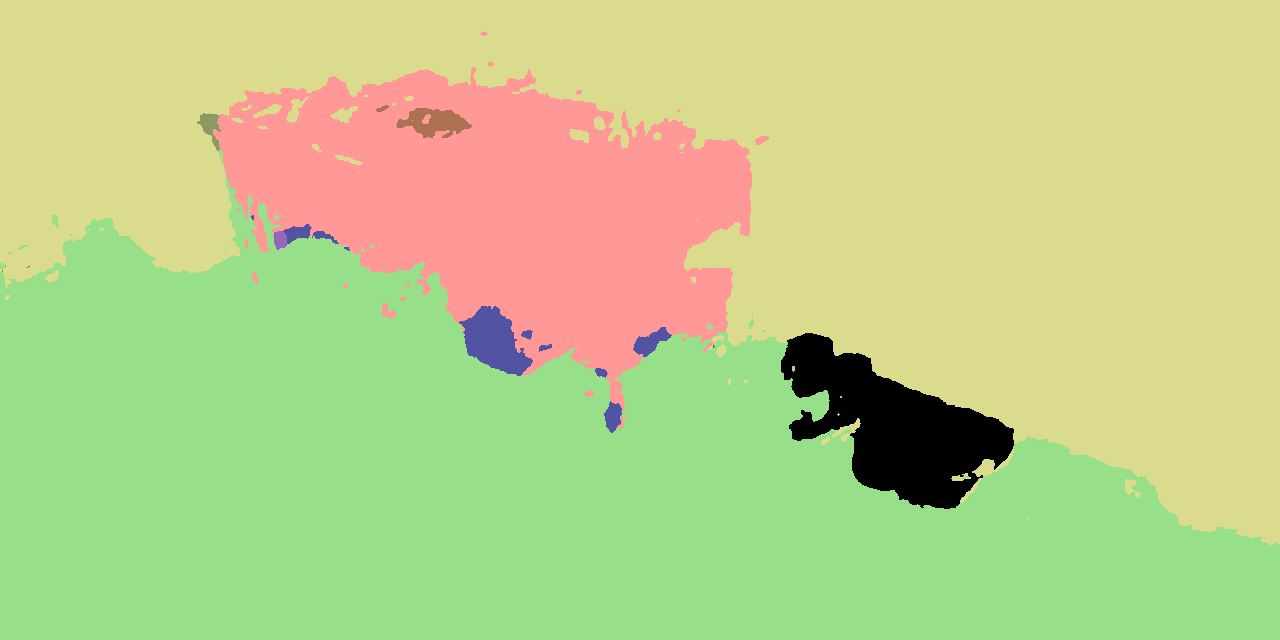

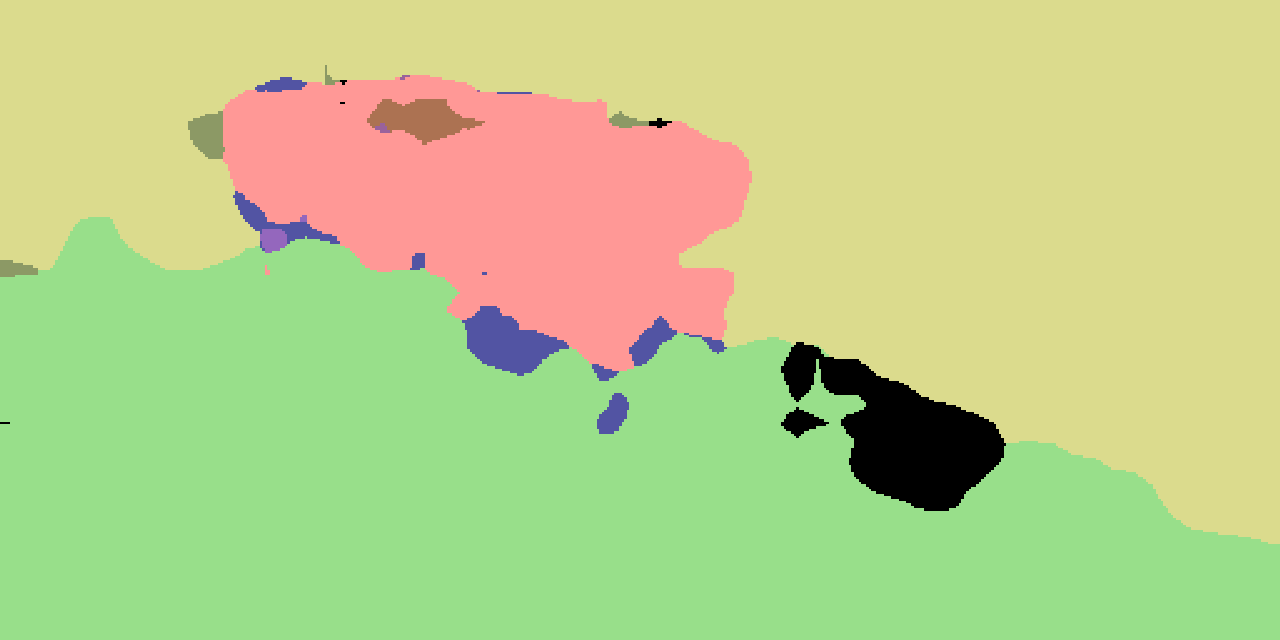

In [116]:
# (labelmap-labelmap2).sum()
# #r= visu.plot_segmentation(seg=np.array( pred )+1,jupyter=True)
# # r= visu.plot_segmentation(seg=np.array( target )+1,jupyter=True)
r= visu.plot_segmentation(seg=labelmap ,jupyter=True)
r= visu.plot_segmentation(seg=labelmap2 ,jupyter=True)